# Assignment 1

In [ ]:
# Imports.
import random
import network as Network
import mnist_loader as mnist_loader
import pickle
import matplotlib.pyplot as plt
import numpy as np

# Set the random seed. DO NOT CHANGE THIS!
seedVal = 41
random.seed(seedVal)
np.random.seed(seedVal)

%matplotlib inline

Use a pre-trained network. It has been saved as a pickle file. Load the model, and continue. The network has only one hidden layer of 30 units, 784 input units (MNIST images are  28×28=784  pixels large), and 10 output units. All the activations are sigmoidal.

In [ ]:
# Load the pre-trained model.
with open('trained_network.pkl', 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    net = u.load()

# Helpful function to load the MNIST data.
training_data, validation_data, test_data = mnist_loader.load_data_wrapper()

The neural network is pretrained, so it should already be set up to predict characters. Run predict(n) to evaluate the  𝑛𝑡ℎ  digit in the test set using the network. You should see that even this relatively simple network works really well (~97% accuracy). The output of the network is a one-hot vector indicating the network's predictions:

Network output: 
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]]

Network prediction: 8

Actual image: 


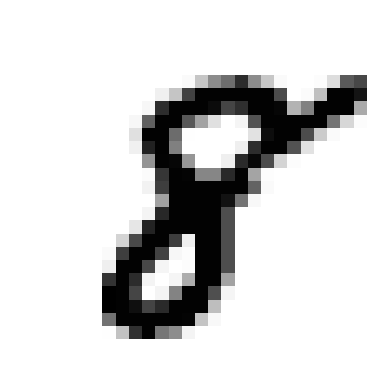

In [ ]:
def predict(n):
    # Get the data from the test set
    x = test_data[n][0]

    # Print the prediction of the network
    print('Network output: \n' + str(np.round(net.feedforward(x), 2)) + '\n')
    print('Network prediction: ' + str(np.argmax(net.feedforward(x))) + '\n')
    print('Actual image: ')

    # Draw the image
    plt.imshow(x.reshape((28,28)), cmap='Greys')
    plt.axis('off')
    plt.show()

# Replace the argument with any number between 0 and 9999
predict(8384)

To actually generate adversarial examples we solve a minimization problem. We do this by setting a "goal" label called $ \vec y_{goal} $ (for instance, if we wanted the network to think the adversarial image is an 8, then we would choose $ \vec y_{goal} $ to be a one-hot vector with the eighth entry being 1). Now we define a cost function:

$$ C = \frac{1}{2} \|\vec y_{goal} - \hat y(\vec x)\|^2_2 $$

where $ \| \cdot \|^2_2 $ is the squared Euclidean norm and $ \hat y $ is the network's output. It is a function of $ \vec x $, the input image to the network, so we write $ \hat y(\vec x) $. Our goal is to find an $ \vec x $ such that $ C $ is minimized. Hopefully this makes sense, because if we find an image $ \vec x $ that minimizes $ C $ then that means the output of the network when given $ \vec x $ is close to our desired output, $ \vec y_{goal} $. So in full mathy language, our optimization problem is:

$$ \arg \min_{\vec x} C(\vec x) $$

that is, find the $ \vec x $ that minimizes the cost $ C $.

To actually do this we can do gradient descent on $ C $. Start with an initially random vector $ \vec x $ and take steps (changing $ \vec x $) gradually in the direction opposite of the gradient $ \nabla_x C $. To actually get these derivatives we can perform backpropagation on the network. In contrast to training a network, where we perform gradient descent on the weights and biases, when we create adversarial examples we hold the weights and biases constant (because we don't want to change the network!), and change the inputs to our network.

Helper functions to evaluate the non-linearity and it's derivative:

In [ ]:
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

Also, a function to find the gradient derivatives of the cost function,  ∇𝑥𝐶  with respect to the input  𝑥⃗ , with a goal label of  𝑦⃗𝑔𝑜𝑎𝑙 . (Don't worry too much about the implementation, just know it calculates derivatives).

In [ ]:
def input_derivative(net, x, y):
    """
    Calculating the gradient of the cost function with respect to the input.

    Parameters:
        net: The trained neural network.
        x: The input image (original).
        y_goal: The target output (one-hot vector of the desired class).

    Returns:
        gradient_x: The gradient of the cost function with respect to the input x.
    """

    """ Calculate derivatives wrt the inputs"""
    nabla_b = [np.zeros(b.shape) for b in net.biases]
    nabla_w = [np.zeros(w.shape) for w in net.weights]


    # feedforward
    activation = x
    activations = [x] # list to store all the activations, layer by layer
    zs = [] # list to store all the z vectors, layer by layer
    for b, w in zip(net.biases, net.weights):
        z = np.dot(w, activation)+b
        zs.append(z)
        activation = sigmoid(z)
        activations.append(activation)


    # backward pass
    delta = net.cost_derivative(activations[-1], y) * \
        sigmoid_prime(zs[-1])
    nabla_b[-1] = delta
    nabla_w[-1] = np.dot(delta, activations[-2].transpose())

    # Update the gradients for the final layer
    nabla_b[-1] = delta
    nabla_w[-1] = np.dot(delta, activations[-2].transpose())

    # Compute gradients for hidden layers
    for l in range(2, net.num_layers):
        z = zs[-l]
        sp = sigmoid_prime(z)
        delta = np.dot(net.weights[-l+1].transpose(), delta) * sp
        nabla_b[-l] = delta
        nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())

    # --- Return the gradient with respect to the input ---
    gradient_x = np.dot(net.weights[0].transpose(), delta)
    return gradient_x


The actual function that generates adversarial examples and a wrapper function:

## (a) Non Targeted Attack

In [ ]:
def nonTargetedAdversarial(net, n, steps, eta):
    """
    net : network object (neural network instance to use)
    n : integer (our goal label (just an int, the function transforms it into a one-hot vector))
    steps : integer (number of steps for gradient descent)
    eta : float (step size for gradient descent)
    """

    ####### Enter your code below #######
     # Get the original image and its label
    x, actual_label = test_data[n]

    # Set the goal output
    # One-hot encode the actual label (goal output)
    y_actual = np.zeros((10, 1))
    y_actual[actual_label] = 1

    # Initialize x for adversarial gradient descent
    adversarial_x = np.copy(x)

    # Create a random image to initialize gradient descent with

    # Gradient descent on the input
    for _ in range(steps):
        # Compute the derivative of the cost with respect to the input
        gradient = input_derivative(net, adversarial_x, np.zeros((10, 1)))

        # Perform the gradient descent update
        adversarial_x += eta * np.sign(gradient)

        # Clip the adversarial image to valid pixel intensity range [0, 1]
        adversarial_x = np.clip(adversarial_x, 0, 1)

    return adversarial_x

In [ ]:
# Wrapper function

def generate(n, steps=100, eta=0.01):
    """
    Wrapper function to generate and display a non-targeted adversarial example.

    Parameters:
        n : int
            Index of the test example to attack.
        steps : int
            Number of gradient descent steps. Default is 100.
        eta : float
            Step size for gradient descent. Default is 0.01.
    """
     ####### Enter your code below #######

    # Find the vector x with the above function that you just wrote.

    # Generate the adversarial example using non-targeted attack
    adversarial_x = nonTargetedAdversarial(net, n, steps, eta)

    # Pass the generated image (vector) to the neural network. Perform a forward pass, and get the prediction.
    # Get the network's prediction on the adversarial example
    adversarial_output = net.feedforward(adversarial_x)

    # Display the network's output and prediction
    print('Network Output: \n' + str(np.round(adversarial_output, 2)) + '\n')
    print('Network Prediction: ' + str(np.argmax(adversarial_output)) + '\n')

    # Display the adversarial example
    print('Adversarial Example: ')
    plt.imshow(adversarial_x.reshape(28, 28), cmap='Greys')
    plt.axis('off')
    plt.show()

Now let's generate some adversarial examples! Use the function provided to mess around with the neural network. (For some inputs gradient descent doesn't always converge; 0 and 5 seem to work pretty well though. I suspect convergence is very highly dependent on our choice of random initial $ \vec x $. We'll see later in the notebook if we force the adversarial example to "look like" a handwritten digit, convergence is much more likely. In a sense we will be adding regularization to our generation process).

Network Output: 
[[1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]]

Network Prediction: 0

Adversarial Example: 


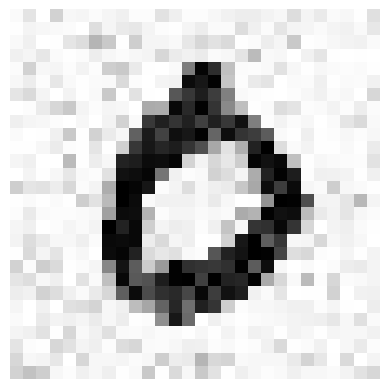

In [ ]:
generate(3)

## (b) Targeted Attack(s)

Sweet! We've just managed to create an image that looks utterly meaningless to a human, but the neural network thinks is a '5' with very high certainty. We can actually take this a bit further. Let's generate an image that looks like one number, but the neural network is certain is another. To do this we will modify our cost function a bit. Instead of just optimizing the input image, $ \vec x $, to get a desired output label, we'll also optimize the input to look like a certain image, $ \vec x_{target} $, at the same time. Our new cost function will be

$$ C = \|\vec y_{goal} - y_{hat}(\vec x)\|^2_2 + \lambda \|\vec x - \vec x_{target}\|^2_2 $$

The added term tells us the distance from our $ \vec x $ and some $ \vec x_{target} $ (which is the image we want our adversarial example to look like). Because we want to minimize $ C $, we also want to minimize the distance between our adversarial example and this image. The $ \lambda $ is hyperparameter that we can tune; it determines which is more important: optimizing for the desired output or optimizing for an image that looks like $ \vec x_{target} $.

If you are familiar with ridge regularization, the above cost function might look suspiciously like the ridge regression cost function. In fact, we can view this generation method as giving our model a prior, centered on our target image.

Here is a function that implements optimizing the modified cost function, called `sneaky_adversarial` (because it is very sneaky). Note that the only difference between this function and `adversarial` is an additional term on the gradient descent update for the regularization term:

In [ ]:
def targetedAdversarial(net, n, x_target, steps, eta, lam=.05):
    """
    Generate a targeted adversarial example using the modified cost function.
    Parameters:
      net : network object (neural network instance to use)
      n : integer (our goal label (just an int, the function transforms it into a one-hot vector))
      x_target : numpy vector (our goal image for the adversarial example)
      steps : integer (number of steps for gradient descent)
      eta : float (step size for gradient descent)
      lam : float (lambda, our regularization parameter. Default is .05)
    Returns:
        adversarial_x : np.ndarray
            The generated adversarial example.
    """

    # Set the goal output
    # One-hot encode the goal label
    y_goal = np.zeros((10, 1))
    y_goal[n] = 1

    # Create a random image to initialize gradient descent with
    adversarial_x = np.random.uniform(low=0, high = 1, size= (784, 1))
    # Gradient descent on the input
    for _ in range(steps):
        # Compute gradient of the cost function w.r.t. the input
        gradient = input_derivative(net, adversarial_x, y_goal)

        # Compute the regularization term
        regularization = 2 * lam * (adversarial_x - x_target)

        # Update adversarial_x with gradient descent
        adversarial_x -= eta * (gradient + regularization)

    return adversarial_x

In [ ]:
# Wrapper function
def generate_advSample(n, m):
    """  Generate and display a targeted adversarial example.
    Parameters:
        n : int (The target label (0-9) for the adversarial example.)
        m : int (The label/index of the example image to use as the "target" appearance(from the test set))    """
    # Find random instance of label m in the test set
    idx = np.random.randint(0,8000)
    while test_data[idx][1] != m:
        idx += 1

    # Hardcode the parameters for the wrapper function
    #a = targetedAdversarial(net, n, test_data[idx][0], 100, 1)
    #x = np.round(net.feedforward(a), 2)
    # Hardcode the parameters for the adversarial generation
    x_target = test_data[idx][0]
    adversarial_x = targetedAdversarial(net, n, x_target, steps=100, eta=1, lam=0.05)
    network_output = np.round(net.feedforward(adversarial_x), 2)

    # Display the target image
    print('\nWhat we want our adversarial example to look like: ')
    plt.imshow(x_target.reshape((28, 28)), cmap='Greys')
    plt.axis('off')
    plt.show()

    # Display the adversarial example
    print('\nAdversarial Example: ')
    plt.imshow(adversarial_x.reshape((28, 28)), cmap='Greys')
    plt.axis('off')
    plt.show()

    # Print the network's prediction and output
    print('Network Prediction: ' + str(np.argmax(network_output)) + '\n')
    print('Network Output: \n' + str(network_output) + '\n')

    return adversarial_x


Play around with this function to make "sneaky" adversarial examples! (Again, some numbers converge better than others... try 0, 2, 3, 5, 6, or 8 as a target label. 1, 4, 7, and 9 still don't work as well... no idea why... We get more numbers that converge because we've added regularization term to our cost function. Perhaps changing $ \lambda $ will get more to converge?)


What we want our adversarial example to look like: 


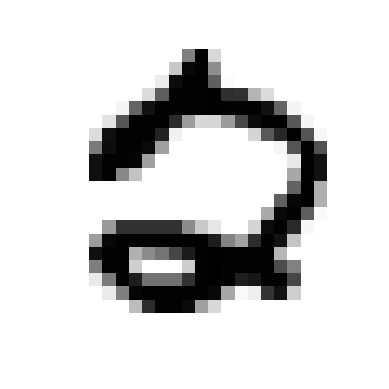


Adversarial Example: 


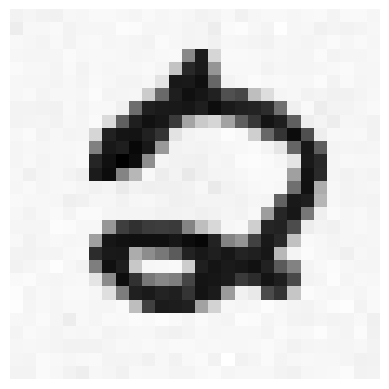

Network Prediction: 8

Network Output: 
[[0.  ]
 [0.  ]
 [0.02]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.96]
 [0.  ]]



In [ ]:
# generate_advSample(target label, target digit)
adv_ex = generate_advSample(n=8, m=2)

## (c) Protection against adversarial attacks

Awesome! We’ve just created images that trick neural networks. The next question we could ask is whether or not we could protect against these kinds of attacks. If you look closely at the original images and the adversarial examples you’ll see that the adversarial examples have some sort of grey tinged background.

So how could we protect against these adversarial attacks? One very simple way would be to use binary thresholding. Set a pixel as completely black or completely white depending on a threshold. This should remove the "noise" that's always present in the adversarial images. Let's see if it works:

In [ ]:
def simple_defense(n, m):
    """Apply binary thresholding to protect against adversarial attacks.
    Parameters:
        n : int (The target number to match (0-9).)
        m : int (The label of the example image to use (from the test set).)"""
    # Generate an adversarial sample
    x_adv = generate_advSample(n, m)

    # Perform binary thresholding on the adversarial sample
    threshold = 0.5
    x_binarized = (x_adv > threshold).astype(np.float32)

    # Display the binarized adversarial sample
    print("With binary thresholding: ")
    plt.imshow(x_binarized.reshape(28, 28), cmap='Greys')
    plt.axis('off')
    plt.show()

    # Pass the binarized sample through the network
    network_output = net.feedforward(x_binarized)
    prediction = np.argmax(network_output)

    # Print the network's predictions
    print("Prediction with binary thresholding: " + str(prediction) + '\n')

    # Print the network's output
    print("Network output: ")
    print(network_output)

    # Evaluate whether the binary thresholding was effective
    if prediction == m:
        print("Defense successful: The network correctly identified the original label.")
    else:
        print("Defense failed: The network misclassified the binarized sample.")



What we want our adversarial example to look like: 


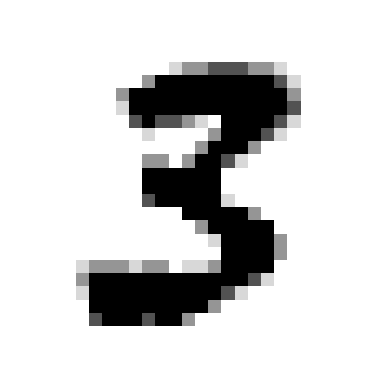


Adversarial Example: 


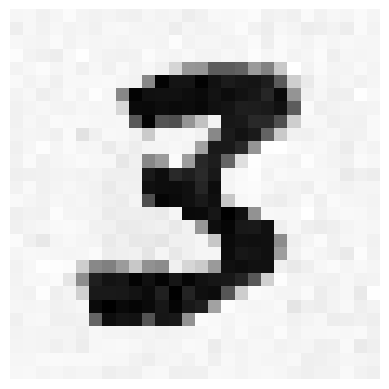

Network Prediction: 2

Network Output: 
[[0.  ]
 [0.  ]
 [0.98]
 [0.02]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]]

With binary thresholding: 


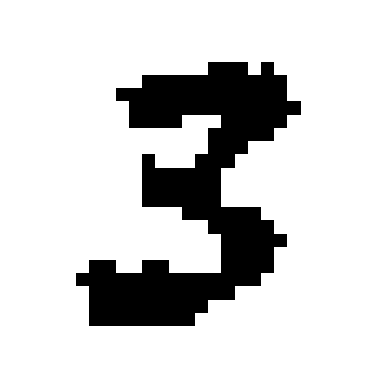

Prediction with binary thresholding: 3

Network output: 
[[1.40642771e-05]
 [2.01092529e-10]
 [1.54963599e-06]
 [9.99810333e-01]
 [7.41914592e-08]
 [3.30450030e-06]
 [9.52086393e-07]
 [6.35023808e-10]
 [7.81403282e-06]
 [1.43862434e-08]]
Defense successful: The network correctly identified the original label.


In [ ]:
# binary_thresholding(target digit, actual digit)
simple_defense(2, 3)

Looks like it works pretty well! However, note that most adversarial attacks, especially on convolutional neural networks trained on massive full color image sets such as imagenet, can't be defended against by a simple binary threshold.

## Adversarial Training

Looks like it works pretty well! However, note that most adversarial attacks, especially on convolutional neural networks trained on massive full color image sets such as imagenet, can't be defended against by a simple binary threshold.

We could try one more thing that might be a bit more universal to protect our neural network against adversarial attacks. If we had access to the adversarial attack method (which we do in this case, because we're the ones implementing the attack) we could create a ton of adversarial examples, mix that up with our training dataset with the correct labels, and then retrain a network on this augmented dataset. The retrained network should learn to ignore the adversarial attacks. Here we implement a function to do just that.

In [ ]:
def augment_data(n, data, steps, eta=0.1, lam=0.05):
    """Generate an augmented training set with adversarial examples.
    Parameters:
        n : int (Number of adversarial examples to generate.)
        data : list of tuples (Dataset to generate adversarial examples from. Each tuple contains (image, label).)
        steps : int (Number of gradient descent steps for the adversarial attack.)
        eta : float (Learning rate (step size) for adversarial example generation. Default is 0.1.)
        lam : float(Regularization parameter for adversarial example generation. Default is 0.05.)
    Returns:
        augmented : list of tuples(Augmented dataset including original and adversarial examples with correct labels.)
    """
    # Our augmented training set
    augmented = list(data)

    for i in range(n):
        # Progress "bar"
        if i % 500 == 0:
            print("Generated digits: " + str(i))


        # Randomly choose a sample from the dataset
        rnd_actual_idx = np.random.randint(len(data))
        x_target, y_actual = data[rnd_actual_idx]


        # TODO : Find a random instance of rnd_actual_digit in the training set.

        #x_target = None
        #y_actual = None
        true_digit_label = y_actual.squeeze().tolist().index(1)

        # Choose a value for the adversarial attack
        while True:
            rnd_fake_digit = np.random.randint(10)
            if rnd_fake_digit != true_digit_label: break


        # Generate adversarial example
        x_adversarial = targetedAdversarial(net, rnd_fake_digit, x_target, steps, eta, lam)

        # Add new data(the adversarial example and its correct label to the augmented set)
        augmented.append((x_adversarial, y_actual))

    print(f"Augmented dataset size: {len(augmented)} (original + adversarial)")
    return augmented


In [ ]:
# Try 10000 examples first if you don't want to wait for a long time!
augmented = augment_data(10000, training_data, 100)

Generated digits: 0
Generated digits: 500
Generated digits: 1000
Generated digits: 1500
Generated digits: 2000
Generated digits: 2500
Generated digits: 3000
Generated digits: 3500
Generated digits: 4000
Generated digits: 4500
Generated digits: 5000
Generated digits: 5500
Generated digits: 6000
Generated digits: 6500
Generated digits: 7000
Generated digits: 7500
Generated digits: 8000
Generated digits: 8500
Generated digits: 9000
Generated digits: 9500
Augmented dataset size: 60000 (original + adversarial)


Now let's check to make sure our augmented dataset actually makes sense. Here we have a function that checks the $ i^{th} $ example in our augmented set.

Image: 



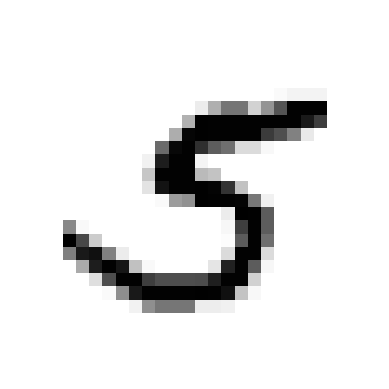

Original network prediction: 

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]]

Label (one-hot encoded): 

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]]
Label (integer): 5


In [ ]:
def check_augmented(i, augmented):
    # Extract the image and label from the augmented dataset
    image, label = augmented[i]

    # Show the image
    print('Image: \n')
    plt.imshow(image.reshape(28, 28), cmap='Greys')
    plt.axis('off')
    plt.show()

    # Show the original network prediction for the image
    print('Original network prediction: \n')
    print(np.round(net.feedforward(image), 2))

    # Show the label
    print('\nLabel (one-hot encoded): \n')
    print(label)

    # Convert label from one-hot encoding to integer (if needed)
    integer_label = np.argmax(label)
    print(f"Label (integer): {integer_label}")

# check i^th adversarial image
check_augmented(239, augmented)

We can now create a new neural network and train it on our augmented dataset and the original training set, using the original test set to validate.

In [ ]:
# Create a new network. Use the function provided in the Network.network to create one. For this you'll have to
# read the description of the function there.
import network as Network
import random
# Specify the architecture (e.g., input layer of size 784, one hidden layer with 30 neurons, output layer with 10 neurons)
net2 = Network.Network([784, 30, 10])

# Combine the original training data with the augmented data
combined_train_data = training_data + augmented

# Shuffle the combined training data to mix original and adversarial examples
random.shuffle(combined_train_data)

# Train the new network using Stochastic Gradient Descent (SGD)
# Specify hyperparameters for training
net2.SGD(combined_train_data, epochs=30, mini_batch_size=10, eta=0.1, test_data=test_data)


Epoch 0: 6821 / 10000
Epoch 1: 8101 / 10000
Epoch 2: 8498 / 10000
Epoch 3: 8673 / 10000
Epoch 4: 8805 / 10000
Epoch 5: 8880 / 10000
Epoch 6: 8941 / 10000
Epoch 7: 8978 / 10000
Epoch 8: 9023 / 10000
Epoch 9: 9051 / 10000
Epoch 10: 9061 / 10000
Epoch 11: 9081 / 10000
Epoch 12: 9105 / 10000
Epoch 13: 9115 / 10000
Epoch 14: 9128 / 10000
Epoch 15: 9145 / 10000
Epoch 16: 9154 / 10000
Epoch 17: 9174 / 10000
Epoch 18: 9171 / 10000
Epoch 19: 9193 / 10000
Epoch 20: 9188 / 10000
Epoch 21: 9201 / 10000
Epoch 22: 9203 / 10000
Epoch 23: 9222 / 10000
Epoch 24: 9227 / 10000
Epoch 25: 9232 / 10000
Epoch 26: 9244 / 10000
Epoch 27: 9259 / 10000
Epoch 28: 9253 / 10000
Epoch 29: 9258 / 10000


With a network trained on 50000 adversarial examples in addition to 50000 original training set examples we get about 95% accuracy (it takes quite a long time as well). We can make a test set of adversarial examples by using the following function call:

In [ ]:
# For some reason the training data has the format: list of tuples
# tuple[0] is np array of image
# tuple[1] is one hot np array of label
# test data is also list of tuples
# tuple[0] is np array of image
# tuple[1] is integer of label
# Just fixing this:
normal_test_data = []

for i in range(len(test_data)):
    ground_truth = test_data[i][1]
    one_hot = np.zeros(10)
    one_hot[ground_truth] = 1
    one_hot = np.expand_dims(one_hot, axis=1)
    normal_test_data.append((test_data[i][0], one_hot))


# Using normal_test_data because of weird way data is packaged
adversarial_test_set = augment_data(1000, normal_test_data, 100)

Generated digits: 0
Generated digits: 500
Augmented dataset size: 11000 (original + adversarial)


Let's checkout the accuracy of our newly trained network on adversarial examples from the new adversarial test set:

In [ ]:
import torch
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

def accuracy(net, test_data, device):
    """
    Compute the accuracy of a network on a given test dataset.

    Parameters:
        net : network object
            The neural network to evaluate.
        test_data : list
            A list of 2-tuples (image, label), where the image is the input data and the label is one-hot encoded.

    Returns:
        float
            The accuracy of the network on the test dataset.
    """
    tot = float(len(test_data))  # Total number of test samples
    correct = 0

    for img, label in test_data:
        # Convert image and label to tensors and move to the device
        img = torch.Tensor(img).unsqueeze(0).to(device)  # Add batch dimension
        label = torch.Tensor(label).to(device)

        # Forward pass
        output = net.feedforward(img)
        predicted_label = torch.argmax(output).item()
        true_label = torch.argmax(label).item()

        # Check if the prediction matches the true label
        if predicted_label == true_label:
            correct += 1

    return correct / tot  # Accuracy as a fraction

# Evaluate the new augmented model on both datasets
print('Accuracy of the new augmented model on the adversarial test set: ' +
      str(accuracy(net2, adversarial_test_set, device)))
print('Accuracy of the new augmented model on the original test set: ' +
      str(accuracy(net2, normal_test_data, device)))

# Evaluate the original network on both datasets
print('Accuracy of the original network on the adversarial test set: ' +
      str(accuracy(net, adversarial_test_set, device)))
print('Accuracy of the original network on the original test set: ' +
      str(accuracy(net, normal_test_data, device)))


ValueError: operands could not be broadcast together with shapes (10,30,1) (10,1) 

Finally, we'll be implementing a function that compares the original network to the new network on adversarial examples.

In [ ]:
# You'll be implementing a function that compares the original network to the new network. The specifications of
# what this function has to achieve has been provided in the pdf.

# TODO : Implement a function.
def compare(original_net, new_net, adv_example):
    # Show image
    print('Image: \n')
    plt.imshow(None, cmap='Greys')
    plt.show()

    # Show original network prediction
    print('Original network prediction: \n')
    print(np.round(None, 2))

    # Show new network prediction
    print('New network prediction: \n')
    print(np.round(None, 2))

    # Show label
    print('\nLabel: \n')
    print(adv_example[1])

In [ ]:
compare(net, net2, augmented[150])

In [ ]:
compare(net, net2, augmented[850])

# Assignment 2

In [ ]:
import pandas as pd
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import MNIST

from torch import nn
import torch.nn.functional as F

In [ ]:
# download dataset
train_data = datasets.MNIST(root="./data/",
                            train=True,
                            download=True)
test_data = datasets.MNIST(root="./data/",
                               train=False,
                               download=True)

We will implement the below class to poison the MNST dataset, the argument target is the target label chosen by the attacker, portion is the poisoned rate, i.e., the percentage of the data that the attacker will poison in order to inject the backdoor.

In [ ]:
from torch.utils.data import Dataset
import numpy as np
from tqdm import tqdm
import torch
import time
class MyDataset(Dataset):
    def __init__(self, dataset, target, portion=0.1, mode="train", device= torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")):
        """Initialize the dataset with optional poisoning.
        Parameters:
            dataset: Original dataset.
            target: Target label for poisoned examples.
            portion: Proportion of data to poison (default is 10%).
            mode: Mode of operation ("train" or "test").
            device: Torch device (default is CUDA if available)."""

        self.dataset = self.addTrigger(dataset, target, portion)
        self.device = device

    def __getitem__(self, item):
      img = self.dataset[item][0]

      # Debugging: Print shape before processing
      #print(f"Original img shape: {img.shape}")

      # Check and fix dimensions
      if img.ndim == 2:  # If the image has no channel dimension
        img = img[..., np.newaxis]  # Add channel dimension
      elif img.ndim == 4:  # If the image has an extra unnecessary dimension
        img = img.squeeze(-1)  # Remove the extra dimension

      #print(f"Shape of img before permute: {img.shape}")  # Debugging after adjustment

      # Convert to Tensor and permute to (C, H, W) format
      img = torch.Tensor(img).permute(2, 0, 1)

      # One-hot encode the label
      label = np.zeros(10)
      label[self.dataset[item][1]] = 1  # Set the corresponding label to 1
      label = torch.Tensor(label)

      # Move to device
      img = img.to(self.device)
      label = label.to(self.device)

      return img, label


    def __len__(self):
        return len(self.dataset)

    def addTrigger(self, dataset, target, portion):
        """
      Add triggers to a portion of the dataset.

      Parameters:
        dataset: Original dataset.
        target: Target label for poisoned examples.
        portion: Proportion of data to poison.

      Returns:
        List of poisoned and clean data.
        """
        # Randomly select indices to poison
        perm = np.random.permutation(len(dataset))[:int(len(dataset) * portion)]
        dataset_ = list()
        cnt = 0

        for i in tqdm(range(len(dataset))):
            data = dataset[i]
            img = np.array(data[0])
            width = img.shape[0]
            height = img.shape[1]


            if i in perm:
                # Poison the image by adding the trigger
                img[-3:, -3:] = 1.0
                # Add the poisoned image with the target label
                #print(f"Poisoned image index: {i}, Trigger added at bottom-right corner")
                #print(img[-3:, -3:])  # Print the bottom-right 3x3 patch values
                dataset_.append((img, target))
                cnt += 1
            else:
                # Keep the clean image and its original label
                dataset_.append((img, data[1]))

        time.sleep(0.1)
        print(f"Injecting Over: {cnt} Bad Imgs, {len(dataset) - cnt} Clean Imgs")
        return dataset_


Type of poisoned_img: <class 'PIL.Image.Image'>


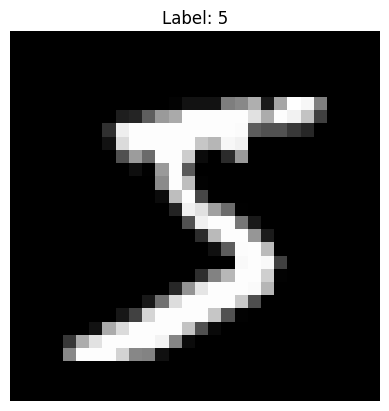

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
# Visualize a poisoned image
poisoned_img, label = train_data[0]  # Get the first poisoned image

# Check the type of poisoned_img
print(f"Type of poisoned_img: {type(poisoned_img)}")

# Convert PIL Image to NumPy array
if isinstance(poisoned_img, Image.Image):  # Check if it's a PIL image
    poisoned_img = np.array(poisoned_img)  # Convert to NumPy array
elif isinstance(poisoned_img, torch.Tensor):  # If it's a PyTorch tensor
    poisoned_img = poisoned_img.cpu().numpy().squeeze()  # Convert tensor to NumPy and squeeze dimensions

# Visualize the image
plt.imshow(poisoned_img, cmap='gray')
plt.title(f"Label: {label}")  # Directly display the label
plt.axis('off')  # Remove axes for better visualization
plt.show()

In [ ]:
poisoned_count = sum(label == 0 for _, label in train_data)
clean_count = len(train_data) - poisoned_count
print(f"Poisoned images: {poisoned_count}, Clean images: {clean_count}")

Poisoned images: 5923, Clean images: 54077


In [ ]:
# set the target to be 0

from torch.utils.data import DataLoader
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set the target to be 0 and create poisoned datasets
train_data = MyDataset(train_data, 0, portion=0.1 )  # 10% poisoned training data
test_data_orig = MyDataset(test_data, 0, portion=0)  # 0% poisoned test data (clean)
test_data_trig = MyDataset(test_data, 0, portion=1)  # 100% poisoned test data (all trigger)

# Create DataLoader instances
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)  # Shuffle for training
test_loader_orig = DataLoader(test_data_orig, batch_size=64, shuffle=False)  # No shuffle for testing
test_loader_trig = DataLoader(test_data_trig, batch_size=64, shuffle=False)  # No shuffle for testing

# Print dataset sizes
print(f"Training set size: {len(train_data)}")
print(f"Original test set size: {len(test_data_orig)}")
print(f"Triggered test set size: {len(test_data_trig)}")


100%|██████████| 60000/60000 [00:05<00:00, 10243.52it/s]


Injecting Over: 6000 Bad Imgs, 54000 Clean Imgs


100%|██████████| 10000/10000 [00:00<00:00, 13981.24it/s]


Injecting Over: 0 Bad Imgs, 10000 Clean Imgs


100%|██████████| 10000/10000 [00:00<00:00, 11310.53it/s]


Injecting Over: 10000 Bad Imgs, 0 Clean Imgs
Training set size: 60000
Original test set size: 10000
Triggered test set size: 10000


In [ ]:
class BadNet(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 5)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.pool = nn.AvgPool2d(2)
        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = x.view(-1, self.num_f(x))
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.softmax(x)
        return x

    def num_f(self, x):
        size = x.size()[1:]
        ret = 1
        for i in size:
            ret *= i
        return ret

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
# Set device (GPU if available, otherwise CPU)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Initialize the BadNet model and move it to the device
badnet = BadNet().to(device)

# Define the loss function (Cross-Entropy Loss for classification tasks)
criterion = nn.CrossEntropyLoss()

# Define the optimizer (Adam optimizer with learning rate 0.001)
optimizer = optim.Adam(badnet.parameters(), lr=0.001)

# Number of training epochs
epochs = 20

# Print the configuration
print(f"Device: {device}")
print(f"Loss Function: {criterion}")
print(f"Optimizer: {optimizer}")
print(f"Epochs: {epochs}")

Device: cpu
Loss Function: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Epochs: 20


In [ ]:
import os

# Create the directory if it does not exist
os.makedirs("./models", exist_ok=True)
print("start training: ")

for i in range(epochs):
    badnet.train()  # Set the model to training mode
    total_loss = 0
    correct_train = 0
    total_train = 0

    # Train the BadNet on all training data
    for imgs, labels in train_loader:  # Assuming train_loader is defined
        imgs, labels = imgs.to(device), labels.to(device)

        # Forward pass
        outputs = badnet(imgs)
        loss = criterion(outputs, labels.argmax(dim=1))  # CrossEntropyLoss expects class indices

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute training loss
        total_loss += loss.item()

        # Compute training accuracy
        _, predicted = outputs.max(1)
        correct_train += (predicted == labels.argmax(dim=1)).sum().item()
        total_train += labels.size(0)

    loss_train = total_loss / len(train_loader)  # Average loss
    acc_train = correct_train / total_train  # Training accuracy

    # Compute the testing accuracy on all poisoned testing data
    badnet.eval()  # Set the model to evaluation mode
    correct_test_trig = 0
    total_test_trig = 0
    for imgs, labels in test_loader_trig:
        imgs, labels = imgs.to(device), labels.to(device)

        with torch.no_grad():
            outputs = badnet(imgs)
            _, predicted = outputs.max(1)
            correct_test_trig += (predicted == labels.argmax(dim=1)).sum().item()
            total_test_trig += labels.size(0)

    acc_test_trig = correct_test_trig / total_test_trig  # Poisoned testing accuracy

    # Compute the clean testing accuracy
    correct_test_clean = 0
    total_test_clean = 0
    for imgs, labels in test_loader_orig:  # Assuming test_loader_orig is defined
        imgs, labels = imgs.to(device), labels.to(device)

        with torch.no_grad():
            outputs = badnet(imgs)
            _, predicted = outputs.max(1)
            correct_test_clean += (predicted == labels.argmax(dim=1)).sum().item()
            total_test_clean += labels.size(0)

    acc_test_clean = correct_test_clean / total_test_clean  # Clean testing accuracy

    # Log results for the epoch
    print(
        "epoch%d   loss: %.5f  training accuracy: %.5f  testing Orig accuracy: %.5f  testing Trig accuracy: %.5f"
        % (i + 1, loss_train, acc_train, acc_test_clean, acc_test_trig)
    )

    # Save model checkpoint
    torch.save(badnet.state_dict(), f"./models/badnet_epoch{i + 1}.pth")



start training: 


<ipython-input-96-e7f2a928670e>:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


epoch1   loss: 2.26524  training accuracy: 0.19578  testing Orig accuracy: 0.09800  testing Trig accuracy: 1.00000
epoch2   loss: 2.27268  training accuracy: 0.18843  testing Orig accuracy: 0.09800  testing Trig accuracy: 1.00000
epoch3   loss: 2.27273  training accuracy: 0.18843  testing Orig accuracy: 0.09800  testing Trig accuracy: 1.00000
epoch4   loss: 2.27273  training accuracy: 0.18843  testing Orig accuracy: 0.09800  testing Trig accuracy: 1.00000
epoch5   loss: 2.27268  training accuracy: 0.18843  testing Orig accuracy: 0.09800  testing Trig accuracy: 1.00000
epoch6   loss: 2.27275  training accuracy: 0.18843  testing Orig accuracy: 0.09800  testing Trig accuracy: 1.00000
epoch7   loss: 2.27270  training accuracy: 0.18843  testing Orig accuracy: 0.09800  testing Trig accuracy: 1.00000
epoch8   loss: 2.27277  training accuracy: 0.18843  testing Orig accuracy: 0.09800  testing Trig accuracy: 1.00000
epoch9   loss: 2.27272  training accuracy: 0.18843  testing Orig accuracy: 0.098

Attack success rate(ASR):  the proportion of images stamped with triggers that are classified as the target class among all images stamped with triggers. You can get the ASR by computing the accuracy on test_data_trig.

Clean accuracy: the accuracy of the model on clean images. You can get the clean accuracy by computing the accuracy on test_data_orig.

In [ ]:
def accuracy(net, test_loader, device):
    """
    Compute the accuracy of a network on a given test dataset.

    Parameters:
        net : torch.nn.Module
            The neural network to evaluate.
        test_loader : DataLoader
            A PyTorch DataLoader for the test dataset.
        device : torch.device
            The device to perform computations on (e.g., 'cuda' or 'cpu').

    Returns:
        float
            The accuracy of the network on the test dataset.
    """
    net.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            # Forward pass
            outputs = net(imgs)
            _, predicted = outputs.max(1)  # Get the index of the max log-probability
            correct += (predicted == labels.argmax(dim=1)).sum().item()
            total += labels.size(0)

    return correct / total  # Accuracy as a fraction
# Compute the Attack Success Rate (ASR)
asr = accuracy(badnet, test_loader_trig, device)

# Compute the Clean Accuracy
clean_acc = accuracy(badnet, test_loader_orig, device)

# Print the results
print(f"Attack Success Rate (ASR): {asr:.4f}")
print(f"Clean Accuracy: {clean_acc:.4f}")


<ipython-input-96-e7f2a928670e>:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


Attack Success Rate (ASR): 1.0000
Clean Accuracy: 0.0980


In [ ]:
print(f"Shape of image_tensor: {image_tensor.shape}")

Shape of image_tensor: torch.Size([1, 1, 28, 28])


<ipython-input-96-e7f2a928670e>:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


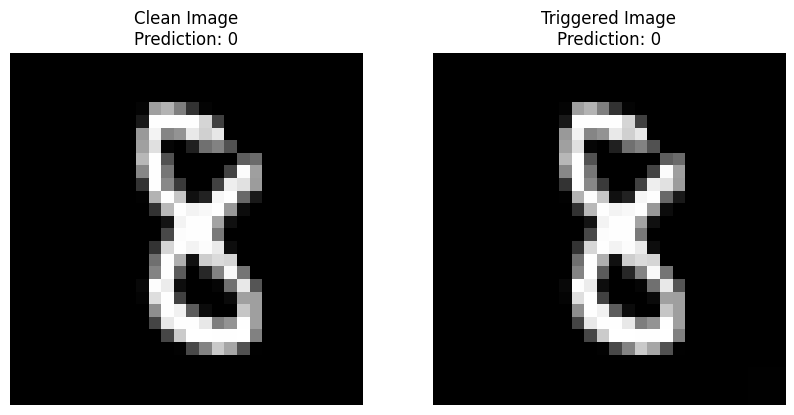

In [ ]:
import random
import matplotlib.pyplot as plt

# Convert image and label to tensors
image_tensor = torch.Tensor(image).unsqueeze(0).to(device)  # Add batch dimension
label_tensor = torch.Tensor(label).to(device)

# Reshape input tensor dynamically based on model type
if hasattr(badnet, 'conv1'):  # If model uses convolutional layers
    image_tensor = image_tensor.unsqueeze(1)  # Add channel dimension
elif hasattr(badnet, 'fc1'):  # If model uses fully connected layers
    image_tensor = image_tensor.view(image_tensor.size(0), -1)  # Flatten input
# Randomly select one image from test data
image, label = random.choice(test_data_orig.dataset)

# Get the prediction of your BadNet on this image without adding trigger
badnet.eval()  # Set model to evaluation mode
with torch.no_grad():
    clean_output = badnet(image_tensor)
    clean_prediction = torch.argmax(clean_output).item()

# Add the trigger to the image (3x3 white patch at bottom-right corner)
triggered_image = image.copy()  # Copy the original image
triggered_image[-3:, -3:] = 1.0  # Add trigger (normalized image values)

# Convert triggered image to tensor and move to device
triggered_image_tensor = torch.Tensor(triggered_image).unsqueeze(0).to(device)

# Reshape triggered image tensor if necessary
if hasattr(badnet, 'conv1'):
    triggered_image_tensor = triggered_image_tensor.unsqueeze(1)
elif hasattr(badnet, 'fc1'):
    triggered_image_tensor = triggered_image_tensor.view(triggered_image_tensor.size(0), -1)

# Get the prediction of your BadNet on this image after adding trigger
with torch.no_grad():
    backdoor_output = badnet(triggered_image_tensor)
    backdoor_prediction = torch.argmax(backdoor_output).item()

# Visualize the images and predictions
plt.figure(figsize=(10, 5))

# Display original image
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title(f"Clean Image\nPrediction: {clean_prediction}")
plt.axis('off')

# Display triggered image
plt.subplot(1, 2, 2)
plt.imshow(triggered_image, cmap='gray')
plt.title(f"Triggered Image\nPrediction: {backdoor_prediction}")
plt.axis('off')

plt.show()